In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights

# Set seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Paths
train_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\train"
val_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\valid"

# Transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Train class distribution: {train_dataset.class_to_idx}")
print(f"Val class distribution: {val_dataset.class_to_idx}")

# Model: CNN + Swin Transformer
class CNN_SwinTransformer(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        self.cnn_out_dim = 1280

        self.swin = swin_t(weights=Swin_T_Weights.DEFAULT)
        self.swin.head = nn.Identity()

        self.cnn_project = nn.Linear(self.cnn_out_dim, 768)

        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn.features(x)        # (B, 1280, 7, 7)
        cnn_feat = cnn_feat.mean(dim=[2, 3])   # (B, 1280)
        cnn_feat = self.cnn_project(cnn_feat)  # (B, 768)

        swin_feat = self.swin(x)               # (B, 768)

        combined = torch.cat([cnn_feat, swin_feat], dim=1)  # (B, 1536)
        return self.classifier(combined)

model = CNN_SwinTransformer(num_classes=4).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

num_epochs = 20
patience = 4
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = train_loss / total
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = val_loss / total
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation improved, model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Final evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

print(f"\nFinal Validation Accuracy: {100 * correct / total:.2f}%")


Train samples: 613, Val samples: 72
Train class distribution: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Val class distribution: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training: 100%|██████████| 20/20 [02:38<00:00,  7.90s/it]


Train Loss: 1.1074 | Train Acc: 47.80%


Validating: 100%|██████████| 3/3 [00:10<00:00,  3.50s/it]


Val Loss: 0.9563 | Val Acc: 48.61%
Validation improved, model saved.

Epoch 2/20


Training: 100%|██████████| 20/20 [02:29<00:00,  7.46s/it]


Train Loss: 0.7759 | Train Acc: 67.86%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


Val Loss: 0.7951 | Val Acc: 63.89%
Validation improved, model saved.

Epoch 3/20


Training: 100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


Train Loss: 0.4417 | Train Acc: 85.48%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]


Val Loss: 0.4746 | Val Acc: 81.94%
Validation improved, model saved.

Epoch 4/20


Training: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it]


Train Loss: 0.2240 | Train Acc: 92.82%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Val Loss: 0.2987 | Val Acc: 90.28%
Validation improved, model saved.

Epoch 5/20


Training: 100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


Train Loss: 0.1535 | Train Acc: 95.27%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]


Val Loss: 0.3980 | Val Acc: 86.11%
No improvement for 1 epochs.

Epoch 6/20


Training: 100%|██████████| 20/20 [02:22<00:00,  7.13s/it]


Train Loss: 0.1860 | Train Acc: 93.80%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


Val Loss: 0.3884 | Val Acc: 87.50%
No improvement for 2 epochs.

Epoch 7/20


Training: 100%|██████████| 20/20 [02:21<00:00,  7.08s/it]


Train Loss: 0.1437 | Train Acc: 95.92%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


Val Loss: 0.3415 | Val Acc: 88.89%
No improvement for 3 epochs.

Epoch 8/20


Training: 100%|██████████| 20/20 [02:22<00:00,  7.10s/it]


Train Loss: 0.1109 | Train Acc: 96.08%


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


Val Loss: 0.3039 | Val Acc: 90.28%
No improvement for 4 epochs.
Early stopping triggered.

Final Validation Accuracy: 90.28%


In [1]:
pip install peft accelerate transformers


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement peft (from versions: none)
ERROR: No matching distribution found for peft

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install peft


     -------------------------------------- 411.1/411.1 kB 2.8 MB/s eta 0:00:00
     ------------------------------------- 354.7/354.7 kB 23.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights

# -----------------------------
# Set Seeds
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Data
# -----------------------------
train_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\train"
val_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\valid"

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.class_to_idx}")

# -----------------------------
# Manual LoRA Injection
# -----------------------------
class LoRALinear(nn.Module):
    def __init__(self, orig_linear, r=8, alpha=16):
        super().__init__()
        self.in_features = orig_linear.in_features
        self.out_features = orig_linear.out_features
        self.r = r
        self.alpha = alpha
        self.scale = alpha / r

        self.lora_A = nn.Linear(self.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, self.out_features, bias=False)

        self.weight = orig_linear.weight
        self.bias = orig_linear.bias
        self.orig_linear = orig_linear
        self.requires_grad_(False)
        self.lora_A.requires_grad_(True)
        self.lora_B.requires_grad_(True)

    def forward(self, x):
        return nn.functional.linear(x, self.weight, self.bias) + self.lora_B(self.lora_A(x)) * self.scale

def inject_lora_into_swin(swin_model):
    for name, module in swin_model.named_modules():
        if isinstance(module, nn.Linear) and module.in_features == module.out_features == 96:
            parent = dict(swin_model.named_modules())[name.rsplit('.', 1)[0]]
            attr = name.split('.')[-1]
            setattr(parent, attr, LoRALinear(module))
    return swin_model

# -----------------------------
# Model
# -----------------------------
class CNN_Swin_LoRA(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        self.cnn_out_dim = 1280

        self.swin = swin_t(weights=Swin_T_Weights.DEFAULT)
        self.swin.head = nn.Identity()
        self.swin = inject_lora_into_swin(self.swin)

        self.cnn_project = nn.Linear(self.cnn_out_dim, 768)

        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn.features(x)
        cnn_feat = cnn_feat.mean(dim=[2, 3])
        cnn_feat = self.cnn_project(cnn_feat)

        swin_feat = self.swin(x)
        combined = torch.cat([cnn_feat, swin_feat], dim=1)
        return self.classifier(combined)

# -----------------------------
# Training
# -----------------------------
model = CNN_Swin_LoRA(num_classes=4).to(device)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

num_epochs = 5
patience = 4
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = train_loss / total
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = val_loss / total
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation improved, model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Final Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

print(f"\nFinal Validation Accuracy: {100 * correct / total:.2f}%")


Train samples: 613, Val samples: 72
Classes: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Trainable parameters: 32889658

Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training: 100%|██████████| 20/20 [03:10<00:00,  9.54s/it]


Train Loss: 1.1059 | Train Acc: 48.78%


Validating: 100%|██████████| 3/3 [00:12<00:00,  4.11s/it]


Val Loss: 0.9399 | Val Acc: 59.72%
Validation improved, model saved.

Epoch 2/20


Training: 100%|██████████| 20/20 [03:14<00:00,  9.72s/it]


Train Loss: 0.7443 | Train Acc: 70.31%


Validating: 100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


Val Loss: 0.8781 | Val Acc: 62.50%
Validation improved, model saved.

Epoch 3/20


Training: 100%|██████████| 20/20 [03:19<00:00,  9.96s/it]


Train Loss: 0.4729 | Train Acc: 83.03%


Validating: 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


Val Loss: 0.6473 | Val Acc: 75.00%
Validation improved, model saved.

Epoch 4/20


Training: 100%|██████████| 20/20 [03:15<00:00,  9.76s/it]


Train Loss: 0.2653 | Train Acc: 90.70%


Validating: 100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Val Loss: 0.5747 | Val Acc: 79.17%
Validation improved, model saved.

Epoch 5/20


Training: 100%|██████████| 20/20 [03:15<00:00,  9.79s/it]


Train Loss: 0.1315 | Train Acc: 95.11%


Validating: 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]


Val Loss: 0.5349 | Val Acc: 87.50%
Validation improved, model saved.

Epoch 6/20


Training:   0%|          | 0/20 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [5]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights
import bitsandbytes as bnb  # For 4-bit quantized layers

# -----------------------------
# Set Seeds
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Data
# -----------------------------
train_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\train"
val_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\valid"

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.class_to_idx}")

# -----------------------------
# Manual QLoRA Injection
# -----------------------------
class QLoRALinear(nn.Module):
    def __init__(self, orig_linear, r=8, alpha=16):
        super().__init__()
        self.in_features = orig_linear.in_features
        self.out_features = orig_linear.out_features
        self.r = r
        self.alpha = alpha
        self.scale = alpha / r

        # Simulate quantization by using bnb 4-bit layers
        self.lora_A = bnb.nn.Linear4bit(self.in_features, r, bias=False, quant_type='nf4')
        self.lora_B = bnb.nn.Linear4bit(r, self.out_features, bias=False, quant_type='nf4')

        self.weight = orig_linear.weight
        self.bias = orig_linear.bias
        self.orig_linear = orig_linear

        self.requires_grad_(False)
        self.lora_A.requires_grad_(True)
        self.lora_B.requires_grad_(True)

    def forward(self, x):
        return nn.functional.linear(x, self.weight, self.bias) + self.lora_B(self.lora_A(x)) * self.scale

def inject_qlora_into_swin(swin_model):
    for name, module in swin_model.named_modules():
        if isinstance(module, nn.Linear) and module.in_features == module.out_features == 96:
            parent = dict(swin_model.named_modules())[name.rsplit('.', 1)[0]]
            attr = name.split('.')[-1]
            setattr(parent, attr, QLoRALinear(module))
    return swin_model

# -----------------------------
# Model Definition
# -----------------------------
class CNN_Swin_QLoRA(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        self.cnn_out_dim = 1280

        self.swin = swin_t(weights=Swin_T_Weights.DEFAULT)
        self.swin.head = nn.Identity()
        self.swin = inject_qlora_into_swin(self.swin)

        self.cnn_project = nn.Linear(self.cnn_out_dim, 768)

        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn.features(x)
        cnn_feat = cnn_feat.mean(dim=[2, 3])
        cnn_feat = self.cnn_project(cnn_feat)

        swin_feat = self.swin(x)
        combined = torch.cat([cnn_feat, swin_feat], dim=1)
        return self.classifier(combined)

# -----------------------------
# Training
# -----------------------------
model = CNN_Swin_QLoRA(num_classes=4).to(device)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

num_epochs = 5
patience = 4
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = train_loss / total
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = val_loss / total
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation improved, model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Final Evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

print(f"\nFinal Validation Accuracy: {100 * correct / total:.2f}%")


The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Train samples: 613, Val samples: 72
Classes: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Trainable parameters: 32889658

Epoch 1/5


Training:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training: 100%|██████████| 20/20 [05:11<00:00, 15.57s/it]


Train Loss: 1.1057 | Train Acc: 48.78%


Validating: 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


Val Loss: 0.9381 | Val Acc: 59.72%
Validation improved, model saved.

Epoch 2/5


Training: 100%|██████████| 20/20 [05:23<00:00, 16.17s/it]


Train Loss: 0.7474 | Train Acc: 69.82%


Validating: 100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Val Loss: 0.8934 | Val Acc: 63.89%
Validation improved, model saved.

Epoch 3/5


Training: 100%|██████████| 20/20 [03:18<00:00,  9.92s/it]


Train Loss: 0.4786 | Train Acc: 84.18%


Validating: 100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


Val Loss: 0.6370 | Val Acc: 75.00%
Validation improved, model saved.

Epoch 4/5


Training: 100%|██████████| 20/20 [21:37<00:00, 64.89s/it]  


Train Loss: 0.2659 | Train Acc: 91.03%


Validating: 100%|██████████| 3/3 [00:16<00:00,  5.40s/it]


Val Loss: 0.5213 | Val Acc: 79.17%
Validation improved, model saved.

Epoch 5/5


Training: 100%|██████████| 20/20 [05:26<00:00, 16.32s/it]


Train Loss: 0.1341 | Train Acc: 95.76%


Validating: 100%|██████████| 3/3 [00:18<00:00,  6.00s/it]


Val Loss: 0.5112 | Val Acc: 87.50%
Validation improved, model saved.

Final Validation Accuracy: 87.50%


In [19]:
pip install bitsandbytes

     ---------------------------------------- 0.0/72.2 MB ? eta -:--:--
     ---------------------------------------- 0.1/72.2 MB 4.1 MB/s eta 0:00:18
     ---------------------------------------- 0.2/72.2 MB 4.1 MB/s eta 0:00:18
     ---------------------------------------- 0.3/72.2 MB 3.5 MB/s eta 0:00:21
     ---------------------------------------- 0.4/72.2 MB 3.8 MB/s eta 0:00:20
     ---------------------------------------- 0.6/72.2 MB 3.3 MB/s eta 0:00:22
     ---------------------------------------- 0.7/72.2 MB 3.4 MB/s eta 0:00:22
     ---------------------------------------- 0.7/72.2 MB 3.4 MB/s eta 0:00:22
     ---------------------------------------- 0.9/72.2 MB 3.2 MB/s eta 0:00:23
      --------------------------------------- 0.9/72.2 MB 3.2 MB/s eta 0:00:23
      --------------------------------------- 1.0/72.2 MB 3.0 MB/s eta 0:00:25
      --------------------------------------- 1.1/72.2 MB 2.8 MB/s eta 0:00:26
      --------------------------------------- 1.2/72.2 MB 2


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install scikit-learn



     ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/10.7 MB 2.6 MB/s eta 0:00:05
     - -------------------------------------- 0.5/10.7 MB 7.6 MB/s eta 0:00:02
     ---- ----------------------------------- 1.1/10.7 MB 10.1 MB/s eta 0:00:01
     ------ --------------------------------- 1.9/10.7 MB 13.3 MB/s eta 0:00:01
     ------ --------------------------------- 1.9/10.7 MB 13.3 MB/s eta 0:00:01
     ---------- ----------------------------- 2.9/10.7 MB 14.4 MB/s eta 0:00:01
     ------------- -------------------------- 3.7/10.7 MB 14.8 MB/s eta 0:00:01
     -------------- ------------------------- 4.0/10.7 MB 15.0 MB/s eta 0:00:01
     -------------------- ------------------- 5.4/10.7 MB 16.4 MB/s eta 0:00:01
     ----------------------- ---------------- 6.3/10.7 MB 17.6 MB/s eta 0:00:01
     ------------------------- -------------- 6.9/10.7 MB 17.7 MB/s eta 0:00:01
     --------------------------- ------------ 7.3


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install torchvision



     ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
     - -------------------------------------- 0.1/1.7 MB 2.3 MB/s eta 0:00:01
     ------- -------------------------------- 0.3/1.7 MB 3.9 MB/s eta 0:00:01
     --------------------- ------------------ 0.9/1.7 MB 8.3 MB/s eta 0:00:01
     ----------------------------- ---------- 1.3/1.7 MB 8.0 MB/s eta 0:00:01
     ---------------------------------------  1.7/1.7 MB 9.8 MB/s eta 0:00:01
     ---------------------------------------- 1.7/1.7 MB 9.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install matplotlib

     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/8.1 MB 1.7 MB/s eta 0:00:05
      --------------------------------------- 0.2/8.1 MB 3.5 MB/s eta 0:00:03
     - -------------------------------------- 0.2/8.1 MB 1.9 MB/s eta 0:00:05
     - -------------------------------------- 0.3/8.1 MB 2.0 MB/s eta 0:00:04
     -- ------------------------------------- 0.4/8.1 MB 2.3 MB/s eta 0:00:04
     --- ------------------------------------ 0.6/8.1 MB 2.9 MB/s eta 0:00:03
     ------ --------------------------------- 1.3/8.1 MB 5.3 MB/s eta 0:00:02
     ------------ --------------------------- 2.6/8.1 MB 8.7 MB/s eta 0:00:01
     --------------- ------------------------ 3.2/8.1 MB 10.2 MB/s eta 0:00:01
     --------------------- ------------------ 4.4/8.1 MB 12.3 MB/s eta 0:00:01
     ------------------------- -------------- 5.2/8.1 MB 12.8 MB/s eta 0:00:01
     --------------------------- ------------ 5.6/8.1 MB 13.6 MB/s e


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_performance(model, val_loader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = nn.functional.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # 1️⃣ Classification Report
    print("\n✅ Classification Report (Precision, Recall, F1-Score, Accuracy):")
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    # 2️⃣ ROC AUC & Curves
    num_classes = len(class_names)
    all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    macro_roc_auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr', average='macro')
    print(f"✅ Macro Average ROC AUC: {macro_roc_auc:.4f}")

    # Per-class ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc_per_class = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc_per_class[i] = auc(fpr[i], tpr[i])
        print(f"Class {i} ({class_names[i]}): ROC AUC = {roc_auc_per_class[i]:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} ({class_names[i]}) AUC = {roc_auc_per_class[i]:.2f}")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess Line")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("multi_class_roc_curve.png")
    plt.close()

    print("✅ ROC curve plot saved as 'multi_class_roc_curve.png'")

# -----------------------------
# Usage Example:
class_names = list(train_dataset.class_to_idx.keys())

model.load_state_dict(torch.load("best_model.pth"))
evaluate_model_performance(model, val_loader, class_names, device)


NameError: name 'model' is not defined

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import DeiTModel, DeiTConfig, DeiTFeatureExtractor

# -----------------------------
# Seeds & Device
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Data Loaders
# -----------------------------
train_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\train"
val_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\valid"

transform = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

class_names = list(train_dataset.class_to_idx.keys())

# -----------------------------
# Model Definition
# -----------------------------
class CNN_DeiT(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        cnn_dim = 1280

        deit_config = DeiTConfig.from_pretrained("facebook/deit-base-patch16-224")
        self.deit = DeiTModel(deit_config)
        deit_dim = deit_config.hidden_size  # typically 768

        # Combine features
        self.project_cnn = nn.Linear(cnn_dim, deit_dim)
        self.head = nn.Sequential(
            nn.Linear(deit_dim*2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn.features(x).mean(dim=[2,3])
        cnn_feat = self.project_cnn(cnn_feat)

        deit_outputs = self.deit(pixel_values=x)
        deit_feat = deit_outputs.last_hidden_state[:,0]  # [CLS] token

        combined = torch.cat([cnn_feat, deit_feat], dim=1)
        return self.head(combined)

model = CNN_DeiT(num_classes=len(class_names)).to(device)
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# -----------------------------
# Training Loop (same as yours)
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

best_val_acc = 0
patience = 4
no_improve = 0
num_epochs = 8

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    total, correct, train_loss = 0,0,0.0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*imgs.size(0)
        correct += (outputs.argmax(1)==labels).sum().item()
        total += labels.size(0)
    print(f"Train acc: {100*correct/total:.2f}% Loss: {train_loss/total:.4f}")

    # Validation
    model.eval()
    total, correct, val_loss = 0,0,0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*imgs.size(0)
            correct += (outputs.argmax(1)==labels).sum().item()
            total += labels.size(0)
    val_acc = 100*correct/total
    print(f"Val acc: {val_acc:.2f}% Loss: {val_loss/total:.4f}")

    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "best_model_deit.pth")
        print("Saved best model!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break


c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.


Trainable params: 91776640

Epoch 1/8


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 20/20 [09:02<00:00, 27.15s/it]


Train acc: 50.41% Loss: 1.0989


100%|██████████| 3/3 [00:29<00:00,  9.74s/it]


Val acc: 50.00% Loss: 1.0392
Saved best model!

Epoch 2/8


100%|██████████| 20/20 [08:39<00:00, 25.99s/it]


Train acc: 63.13% Loss: 0.8387


100%|██████████| 3/3 [00:17<00:00,  5.82s/it]


Val acc: 59.72% Loss: 0.9228
Saved best model!

Epoch 3/8


100%|██████████| 20/20 [09:13<00:00, 27.70s/it]


Train acc: 75.37% Loss: 0.6250


100%|██████████| 3/3 [00:29<00:00,  9.81s/it]


Val acc: 66.67% Loss: 0.7009
Saved best model!

Epoch 4/8


100%|██████████| 20/20 [13:13<00:00, 39.67s/it]


Train acc: 88.91% Loss: 0.3640


100%|██████████| 3/3 [00:49<00:00, 16.53s/it]


Val acc: 80.56% Loss: 0.4662
Saved best model!

Epoch 5/8


100%|██████████| 20/20 [06:20<00:00, 19.03s/it]


Train acc: 94.29% Loss: 0.1947


100%|██████████| 3/3 [00:13<00:00,  4.49s/it]


Val acc: 86.11% Loss: 0.4187
Saved best model!

Epoch 6/8


100%|██████████| 20/20 [13:48<00:00, 41.43s/it]


Train acc: 94.13% Loss: 0.1627


100%|██████████| 3/3 [00:13<00:00,  4.59s/it]


Val acc: 86.11% Loss: 0.3596

Epoch 7/8


100%|██████████| 20/20 [09:18<00:00, 27.95s/it]


Train acc: 94.78% Loss: 0.1409


100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


Val acc: 90.28% Loss: 0.4036
Saved best model!

Epoch 8/8


100%|██████████| 20/20 [04:10<00:00, 12.55s/it]


Train acc: 96.74% Loss: 0.0942


100%|██████████| 3/3 [00:14<00:00,  4.88s/it]

Val acc: 86.11% Loss: 0.5271


In [8]:
class_names = [
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
    'normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
]


  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 3/3 [00:13<00:00,  4.51s/it]



Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.94      0.74      0.83        23
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.94      0.81      0.87        21
                                          normal       1.00      1.00      1.00        13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.65      1.00      0.79        15

                                        accuracy                           0.86        72
                                       macro avg       0.89      0.89      0.87        72
                                    weighted avg       0.89      0.86      0.86        72



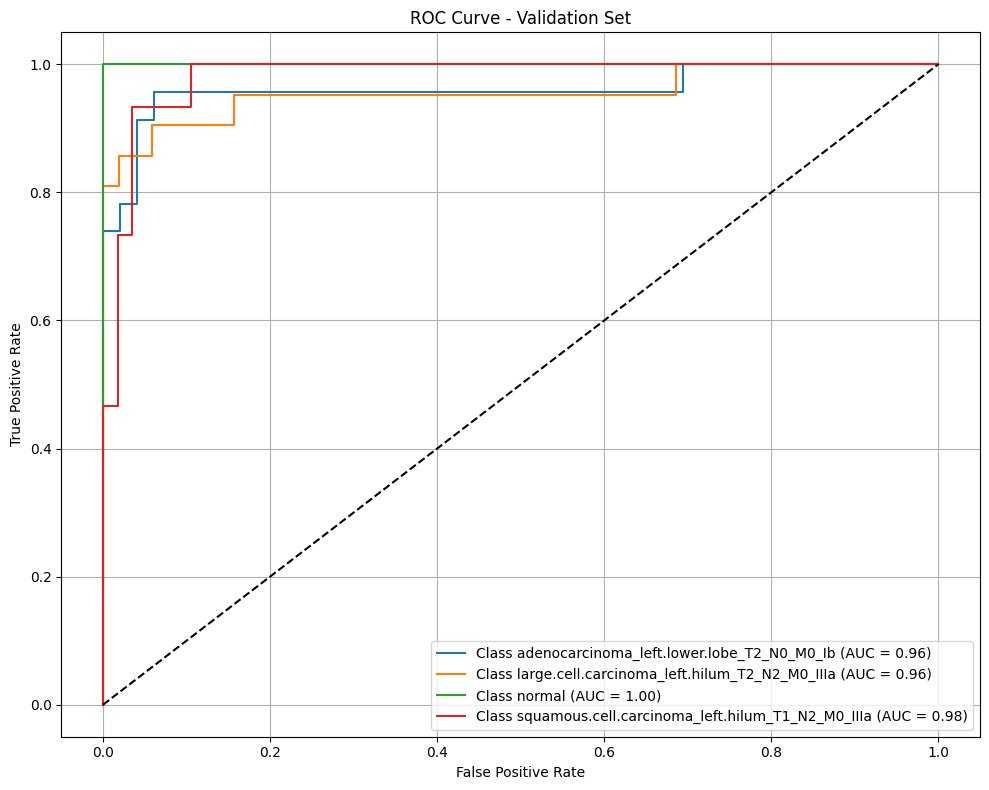

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Collect predictions and labels
all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)

        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Accuracy, Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ROC Curve (multi-class)
n_classes = len(class_names)
y_true_bin = label_binarize(all_labels, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()


In [6]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/11.3 MB 1.3 MB/s eta 0:00:09
      --------------------------------------- 0.2/11.3 MB 1.6 MB/s eta 0:00:08
     - -------------------------------------- 0.3/11.3 MB 1.7 MB/s eta 0:00:07
     - -------------------------------------- 0.4/11.3 MB 1.8 MB/s eta 0:00:06
     - -------------------------------------- 0.5/11.3 MB 1.7 MB/s eta 0:00:07
     - -------------------------------------- 0.5/11.3 MB 1.7 MB/s eta 0:00:07
     -- ------------------------------------- 0.6/11.3 MB 1.6 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/11.3 MB 1.7 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/11.3 MB 1.6 MB/s eta 0:00:07
     -- ------------------------------------- 0.8/11.3 MB 1.5 MB/s eta 0:00:08
     -- --


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install transformers timm


     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
      --------------------------------------- 0.1/2.5 MB 871.5 kB/s eta 0:00:03
     --- ------------------------------------ 0.2/2.5 MB 2.1 MB/s eta 0:00:02
     ------- -------------------------------- 0.5/2.5 MB 3.8 MB/s eta 0:00:01
     ---------------- ----------------------- 1.0/2.5 MB 5.4 MB/s eta 0:00:01
     --------------------------------- ------ 2.1/2.5 MB 8.8 MB/s eta 0:00:01
     ---------------------------------------  2.5/2.5 MB 8.8 MB/s eta 0:00:01
     ---------------------------------------- 2.5/2.5 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import DeiTModel, DeiTConfig
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

# -----------------------------
# Seeds & Device
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Data Loaders
# -----------------------------
train_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\train"
val_dir = r"D:\Downloads\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\data\valid"

transform = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

class_names = list(train_dataset.class_to_idx.keys())

# -----------------------------
# Model Definition
# -----------------------------
class CNN_DeiT(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # CNN: EfficientNet B0
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        cnn_dim = 1280

        # DeiT model
        deit_config = DeiTConfig.from_pretrained("facebook/deit-base-patch16-224")
        self.deit = DeiTModel(deit_config)
        deit_dim = deit_config.hidden_size  # typically 768

        # Ensure DeiT is trainable
        for param in self.deit.parameters():
            param.requires_grad = True

        # Project CNN features
        self.project_cnn = nn.Sequential(
            nn.Linear(cnn_dim, deit_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Final classifier head
        self.head = nn.Sequential(
            nn.Linear(deit_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn.features(x).mean(dim=[2,3])  # GAP
        cnn_proj = self.project_cnn(cnn_feat)

        deit_outputs = self.deit(pixel_values=x)
        deit_feat = deit_outputs.last_hidden_state[:,0]  # [CLS] token

        combined = torch.cat([cnn_proj, deit_feat], dim=1)
        return self.head(combined)

model = CNN_DeiT(num_classes=len(class_names)).to(device)
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# -----------------------------
# Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=3)
main_scheduler = CosineAnnealingLR(optimizer, T_max=22)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[3])

scaler = GradScaler()

model.load_state_dict(torch.load("best_model_deit.pth"))
start_epoch = 15 + 1  # Resume from epoch 16
num_epochs = 25       # New target

# Resume training loop
for epoch in range(start_epoch, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    model.train()
    total, correct, train_loss = 0,0,0.0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    print(f"Train acc: {100 * correct / total:.2f}% Loss: {train_loss / total:.4f}")

    # Validation
    model.eval()
    total, correct, val_loss = 0,0,0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Val acc: {val_acc:.2f}% Loss: {val_loss / total:.4f}")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "best_model_deit.pth")
        print("✅ Saved best model!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("⛔ Early stopping triggered.")
            break


You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.


Trainable params: 91776640


C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_2772\1891229087.py:115: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



Epoch 16/25


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_2772\1891229087.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 20/20 [05:13<00:00, 15.68s/it]


Train acc: 96.74% Loss: 0.4441


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_2772\1891229087.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 3/3 [00:40<00:00, 13.62s/it]


Val acc: 93.06% Loss: 0.5725

Epoch 17/25


  0%|          | 0/20 [00:10<?, ?it/s]


KeyboardInterrupt: 

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_2772\3436817482.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 3/3 [00:12<00:00,  4.28s/it]



📊 Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.92      0.96      0.94        23
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       1.00      0.86      0.92        21
                                          normal       1.00      1.00      1.00        13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.82      0.93      0.88        15

                                        accuracy                           0.93        72
                                       macro avg       0.94      0.94      0.93        72
                                    weighted avg       0.94      0.93      0.93        72



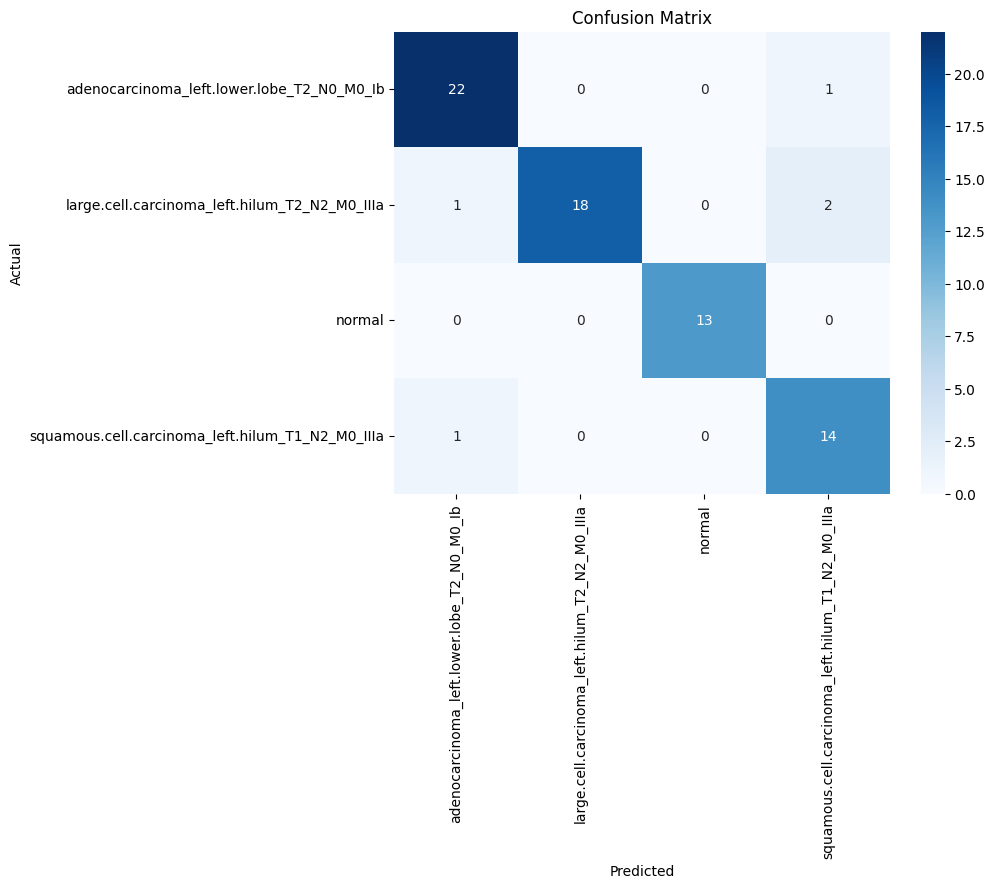

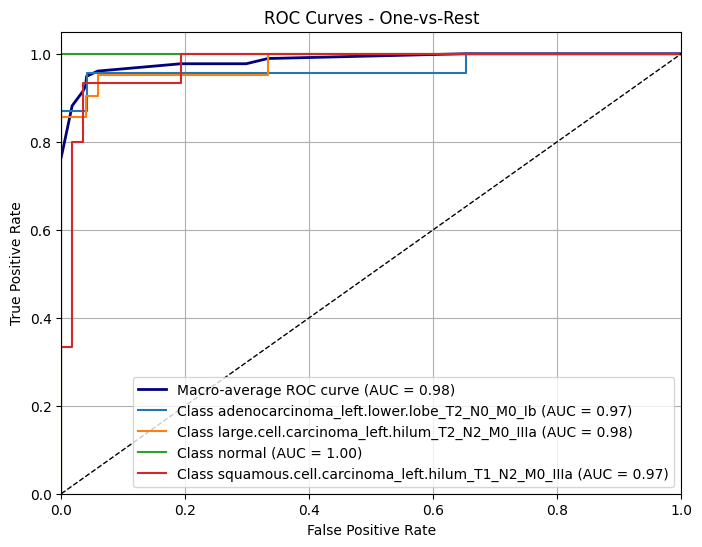

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load best model
model.load_state_dict(torch.load("best_model_deit.pth"))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with autocast():
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Print classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC (One-vs-Rest)
n_classes = len(class_names)
labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], color="navy", label=f"Macro-average ROC curve (AUC = {roc_auc['macro']:.2f})", lw=2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - One-vs-Rest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [10]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import DeiTModel, DeiTConfig
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

# -----------------------------
# Seed & Device Setup
# -----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Dataset & Transforms
# -----------------------------
train_dir = r"D:\\Downloads\\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\\data\\train"
val_dir = r"D:\\Downloads\\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\\data\\valid"

transform = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

class_names = list(train_dataset.class_to_idx.keys())

# -----------------------------
# Hybrid CNN + DeiT Model
# -----------------------------
class CNN_DeiT_Hybrid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        self.cnn_out_channels = 1280

        deit_config = DeiTConfig.from_pretrained("facebook/deit-base-patch16-224")
        self.deit = DeiTModel(deit_config)
        self.deit_dim = deit_config.hidden_size

        self.patch_proj = nn.Linear(self.cnn_out_channels, self.deit_dim)

        self.cls_head = nn.Sequential(
            nn.LayerNorm(self.deit_dim),
            nn.Linear(self.deit_dim, num_classes)
        )

    def forward(self, x):
        feats = self.cnn.features(x)  # (B, 1280, H, W)
        B, C, H, W = feats.shape
        feats = feats.flatten(2).transpose(1, 2)  # (B, N, C)
        tokens = self.patch_proj(feats)  # (B, N, deit_dim)

        cls_token = self.deit.embeddings.cls_token.expand(B, -1, -1)
        input_tokens = torch.cat((cls_token, tokens), dim=1)

        pos_embed = self.deit.embeddings.position_embeddings[:, :input_tokens.size(1), :]
        input_tokens = input_tokens + pos_embed

        x = self.deit.encoder(input_tokens)
        cls_output = x.last_hidden_state[:, 0]  # CLS token

        return self.cls_head(cls_output)

# -----------------------------
# Initialize Model, Loss, Optimizer
# -----------------------------
model = CNN_DeiT_Hybrid(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=3)
main_scheduler = CosineAnnealingLR(optimizer, T_max=22)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[3])

scaler = GradScaler()
best_val_acc = 0.0
patience = 5
no_improve = 0

# -----------------------------
# Resume from checkpoint (optional)
# -----------------------------
start_epoch = 18
if os.path.exists("best_model_cnn_deit.pth"):
    model.load_state_dict(torch.load("best_model_cnn_deit.pth"))
    print(f"✅ Loaded checkpoint for continued training from epoch {start_epoch}")

# -----------------------------
# Training Loop
# -----------------------------
num_epochs = 25
for epoch in range(start_epoch, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    model.train()
    total, correct, train_loss = 0, 0, 0.0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    print(f"Train acc: {100 * correct / total:.2f}% Loss: {train_loss / total:.4f}")

    # Validation
    model.eval()
    total, correct, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Val acc: {val_acc:.2f}% Loss: {val_loss / total:.4f}")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "best_model_cnn_deit.pth")
        print("✅ Saved best model!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("⛔ Early stopping triggered.")
            break


You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.
C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_18948\2453961672.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


✅ Loaded checkpoint for continued training from epoch 18

Epoch 18/25


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_18948\2453961672.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 20/20 [03:27<00:00, 10.37s/it]


Train acc: 96.41% Loss: 0.4400


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\GANDHIRAJ J\AppData\Local\Temp\ipykernel_18948\2453961672.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


Val acc: 94.44% Loss: 0.5134
✅ Saved best model!

Epoch 19/25


100%|██████████| 20/20 [02:47<00:00,  8.38s/it]


Train acc: 98.37% Loss: 0.3867


100%|██████████| 3/3 [00:11<00:00,  3.70s/it]


Val acc: 93.06% Loss: 0.5185

Epoch 20/25


100%|██████████| 20/20 [03:17<00:00,  9.89s/it]


Train acc: 99.35% Loss: 0.3665


100%|██████████| 3/3 [00:16<00:00,  5.65s/it]


Val acc: 90.28% Loss: 0.6244

Epoch 21/25


100%|██████████| 20/20 [03:49<00:00, 11.48s/it]


Train acc: 99.35% Loss: 0.3662


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


Val acc: 90.28% Loss: 0.6666

Epoch 22/25


100%|██████████| 20/20 [03:51<00:00, 11.60s/it]


Train acc: 95.76% Loss: 0.4549


100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


Val acc: 83.33% Loss: 0.7993

Epoch 23/25


100%|██████████| 20/20 [03:49<00:00, 11.46s/it]


Train acc: 96.74% Loss: 0.4363


100%|██████████| 3/3 [00:16<00:00,  5.54s/it]

Val acc: 90.28% Loss: 0.6433
⛔ Early stopping triggered.


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\n📊 Evaluation Metrics:")
    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall:    {recall:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC AUC Curve for Binary Classification
    if len(class_names) == 2:
        y_true = np.array(all_labels)
        y_scores = np.array(all_probs)[:, 1]
        auc = roc_auc_score(y_true, y_scores)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    return acc, precision, recall, f1


c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Evaluation Metrics:
✅ Accuracy:  0.9444
✅ Precision: 0.9475
✅ Recall:    0.9444
✅ F1 Score:  0.9438


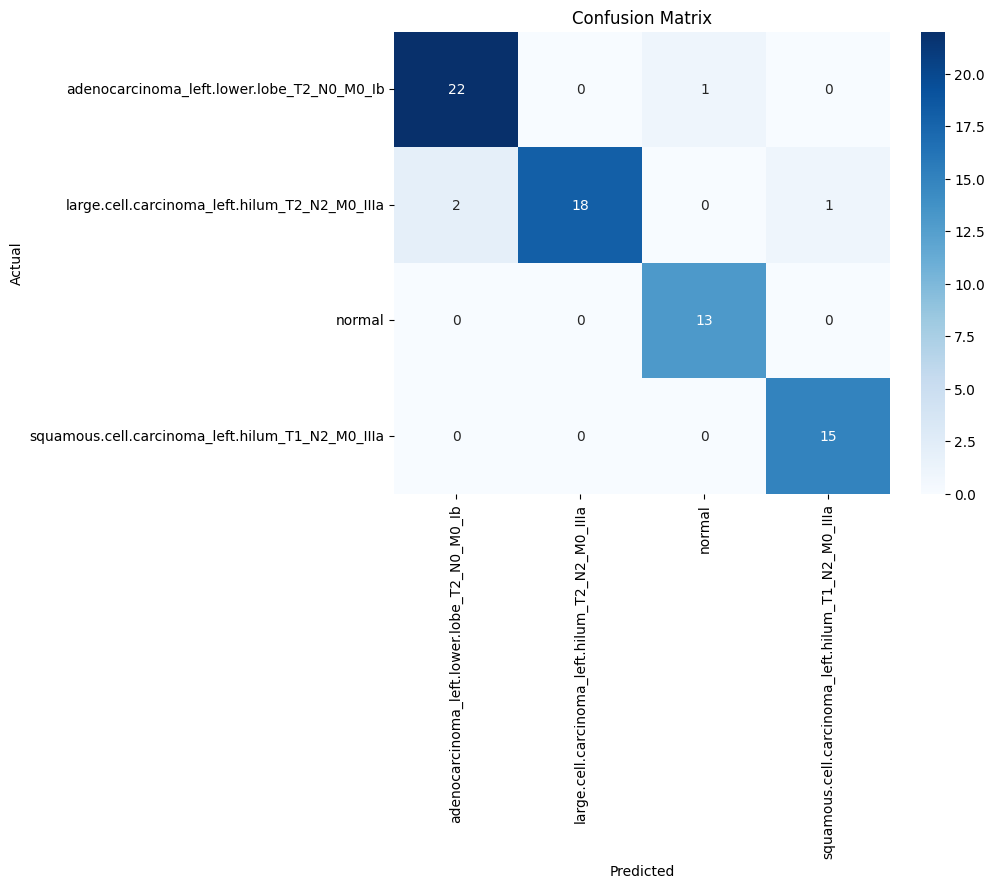

(0.9444444444444444, 0.9474619708994708, 0.9444444444444444, 0.943766358736236)

In [8]:
# Load best model before evaluation
model.load_state_dict(torch.load("best_model_cnn_deit.pth"))

# Evaluate on validation set
evaluate_model(model, val_loader, device, class_names)


In [11]:
test_dir = r"D:\\Downloads\\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\\data\\test"

test_dataset = datasets.ImageFolder(test_dir, transform=transform['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
# TESTING ACCURACY
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_model_cnn_deit.pth", map_location=device))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Compute metrics
report = classification_report(all_labels, all_preds, output_dict=True)
accuracy = accuracy_score(all_labels, all_preds)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"\n📊 Test Evaluation Metrics:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print(f"✅ AUC-ROC:   {auc:.4f}")



📊 Test Evaluation Metrics:
✅ Accuracy:  0.8317
✅ Precision: 0.8447
✅ Recall:    0.8317
✅ F1 Score:  0.8313
✅ AUC-ROC:   0.9557


In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

# 🧠 Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📁 Path to training data
train_dir = r"D:\\Downloads\\CT_SCAN_LUNG_NODULES_EXTRACTEDFILE\\data\\train"

# 🔁 Transform (same as validation)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# 📦 Dataset and Dataloader
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
class_names = list(train_dataset.class_to_idx.keys())

# ✅ Load your CNN+Transformer model class (same as in your training code)
from torchvision import models
from transformers import DeiTModel, DeiTConfig
import torch.nn as nn

class CNN_DeiT_Hybrid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.cnn.classifier = nn.Identity()
        self.cnn_out_channels = 1280
        deit_config = DeiTConfig.from_pretrained("facebook/deit-base-patch16-224")
        self.deit = DeiTModel(deit_config)
        self.deit_dim = deit_config.hidden_size
        self.patch_proj = nn.Linear(self.cnn_out_channels, self.deit_dim)
        self.cls_head = nn.Sequential(
            nn.LayerNorm(self.deit_dim),
            nn.Linear(self.deit_dim, num_classes)
        )

    def forward(self, x):
        feats = self.cnn.features(x)
        B, C, H, W = feats.shape
        feats = feats.flatten(2).transpose(1, 2)
        tokens = self.patch_proj(feats)
        cls_token = self.deit.embeddings.cls_token.expand(B, -1, -1)
        input_tokens = torch.cat((cls_token, tokens), dim=1)
        pos_embed = self.deit.embeddings.position_embeddings[:, :input_tokens.size(1), :]
        input_tokens = input_tokens + pos_embed
        x = self.deit.encoder(input_tokens)
        cls_output = x.last_hidden_state[:, 0]
        return self.cls_head(cls_output)

# 🔄 Load model and weights
model = CNN_DeiT_Hybrid(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("best_model_cnn_deit.pth", map_location=device))
model.eval()

# 🔍 Collect predictions
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 📊 Metrics
report = classification_report(all_labels, all_preds, output_dict=True)
accuracy = accuracy_score(all_labels, all_preds)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

# 📌 Output
print("\n📊 Training Evaluation Metrics:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print(f"✅ AUC-ROC:   {auc:.4f}")


You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.



📊 Training Evaluation Metrics:
✅ Accuracy:  0.9837
✅ Precision: 0.9841
✅ Recall:    0.9837
✅ F1 Score:  0.9837
✅ AUC-ROC:   0.9995
